In [1]:
import sys,os
import numpy as np
import matplotlib.pyplot as plt
from pkg_resources import resource_filename
from desiutil.log import get_logger
from desitarget import cuts
#import astropy.io.fits as pyfits
import fitsio
import healpy as hp


In [2]:
def mag2flux(mag) :
    return 10**(-0.4*(mag-22.5))


In [3]:
def flux2mag(flux) :
    mag = -2.5*np.log10(flux*(flux>0)+0.001*(flux<=0)) + 22.5
    mag[(flux<=0)] = 0.
    return mag


In [4]:
def prof(x,y,bins) :
    '''
    what AJR calls the '1d plots'; e.g., normalized density versus x
    '''
    h0,bins=np.histogram(x,bins=bins)
    hx,bins=np.histogram(x,bins=bins,weights=x)
    hy,bins=np.histogram(x,bins=bins,weights=y)
    hy2,bins=np.histogram(x,bins=bins,weights=y**2)
    ii=h0>2
    mx=hx[ii]/h0[ii]
    my=hy[ii]/h0[ii]
    var=hy2[ii]/h0[ii]-my**2
    ey=np.sqrt(var*(var>0))/np.sqrt(h0[ii])
    return mx,my,ey


In [5]:
def colorplot(ra,dec,z,vmin=None,vmax=None) :
    nbins=300
    raoffset=80.
    rap=(ra+raoffset)%360
    h0,xbins,ybins = np.histogram2d(rap,dec,bins=nbins)
    hz,xbins,ybins = np.histogram2d(rap,dec,bins=nbins,weights=z*(z>=0))
    mz=hz/(h0+(h0==0))*(h0>0)
    plt.imshow(mz.T,origin=0,extent=(xbins[0]-raoffset,xbins[-1]-raoffset,ybins[0],ybins[-1]),aspect="auto",vmin=vmin,vmax=vmax)
    plt.colorbar()


In [6]:
target="ELG"
if target == 'LRG':
    colorcuts_function = cuts.isLRG_colors
elif target == 'ELG':
    colorcuts_function = cuts.isELG_colors
elif target == 'QSO':
    colorcuts_function = cuts.isQSO_colors
else:
    colorcuts_function = None


In [7]:
#truthf = '/global/cscratch1/sd/raichoor/tmpdir/tmp.dr7.41ra44.-1dec0.clean.deep.fits' #original
truthf = '/global/cscratch1/sd/raichoor/desi_mcsyst/desi_mcsyst_truth.dr7.34ra38.-7dec-3.fits' #new HSC

In [8]:
truth  = fitsio.read(truthf,1)
print(truth.dtype.names)

('brickname', 'objid', 'type', 'ra', 'dec', 'g', 'r', 'z', 'w1', 'w2', 'galdepth_g', 'galdepth_r', 'galdepth_z', 'hsc_object_id', 'hsc_ra', 'hsc_dec', 'hsc_mizuki_photoz_best')


In [9]:
print(len(truth))
gmag  = truth["g"]
w = gmag < 24.5
truth = truth[w]
print(len(truth))
gmag  = truth["g"]
rmag  = truth["r"]
zmag  = truth["z"]


549181
156861


/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()


In [10]:
gflux = mag2flux(truth["g"])
rflux = mag2flux(truth["r"])
zflux = mag2flux(truth["z"])
w1flux = np.zeros(gflux.shape)
w2flux = np.zeros(gflux.shape)

In [11]:
true_selection = colorcuts_function(gflux=gflux, rflux=rflux, zflux=zflux, w1flux=w1flux, w2flux=w2flux, south=True)
star_selection = ((gmag-rmag)>(1.5*(rmag-zmag)+0.0))&((gmag-rmag)<(1.5*(rmag-zmag)+0.4))&((gmag-rmag)>(-1.5*(rmag-zmag)+0.3))&((gmag-rmag)<(-1.5*(rmag-zmag)+2.0))
true_mean=np.mean(true_selection.astype(float))


/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py:315: RuntimeWarning: invalid value encountered in greater
  elg &= r - z > 0.3                  # blue cut.
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py:316: RuntimeWarning: invalid value encountered in less
  elg &= r - z < 1.6                  # red cut.
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py:317: RuntimeWarning: invalid value encountered in less
  elg &= g - r < -1.2*(r - z) + 1.6   # OII flux cut.
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py:323: RuntimeWarning: invalid value encountered in less
  elg &= g - r < 1.15*(r - z) - 0.15
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid valu

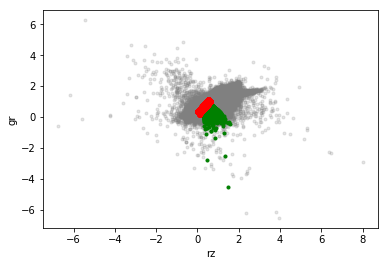

In [12]:
#plt.figure("model")
#plt.subplot(1,2,1)
plt.plot(rmag-zmag,gmag-rmag,".",alpha=0.2,color="gray")
plt.plot((rmag-zmag)[true_selection],(gmag-rmag)[true_selection],".",alpha=1,color="green")
plt.plot((rmag-zmag)[star_selection],(gmag-rmag)[star_selection],".",alpha=1,color="red")
plt.xlabel("rz")
plt.ylabel("gr")
plt.show()

13.8057 24.5 156861


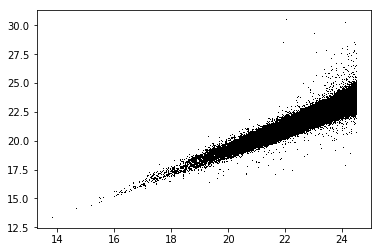

(array([    1,    14,    67,   219,   916,  2808,  7524, 18527, 58615, 68169]), array([ 14. ,  15.1,  16.2,  17.3,  18.4,  19.5,  20.6,  21.7,  22.8,
        23.9,  25. ]))


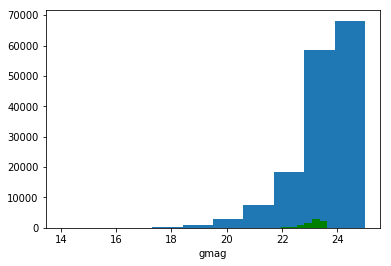

In [13]:
#plt.subplot(1,2,2)
print(min(gmag),max(gmag),len(gmag))
plt.plot(gmag,rmag,'k,')
plt.show()
h = np.histogram(gmag,range=(14,25))
print(h)
plt.hist(gmag,range=(14,25))
plt.hist(gmag[true_selection],bins=40,color="green",range=(14,25))
plt.xlabel("gmag")

plt.show()

In [14]:
seed = 1
rand = np.random.RandomState(seed)

In [21]:
#read in DR8 properties map
pixfn      = '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/pixweight/pixweight-dr8-0.31.1.fits'
pix,header=fitsio.read(pixfn,header=True)
HPXNSIDE=header["HPXNSIDE"]
print(pix.dtype.names)
print("number of pixels=",pix.size)
ii=np.where((pix["GALDEPTH_G"]>0)&(pix["GALDEPTH_R"]>0)&(pix["GALDEPTH_Z"]>0)&(pix["FRACAREA"]>0.01))[0]
npix=ii.size
print(npix)


('HPXPIXEL', 'FRACAREA', 'STARDENS', 'EBV', 'PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z', 'GALDEPTH_G', 'GALDEPTH_R', 'GALDEPTH_Z', 'PSFDEPTH_W1', 'PSFDEPTH_W2', 'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z', 'ELG', 'LRG', 'QSO', 'BGS_ANY', 'MWS_ANY', 'ALL', 'STD_FAINT', 'STD_BRIGHT', 'LRG_1PASS', 'LRG_2PASS', 'BGS_FAINT', 'BGS_BRIGHT', 'BGS_WISE', 'MWS_BROAD', 'MWS_MAIN_RED', 'MWS_MAIN_BLUE', 'MWS_WD', 'MWS_NEARBY')
number of pixels= 786432
374065


In [22]:
pix = pix[ii]
print(len(pix))

def thphi2radec(theta,phi):
    return 180./np.pi*phi,-(180./np.pi*theta-90)
th,phi = hp.pix2ang(HPXNSIDE,pix['HPXPIXEL'])
ra,dec = thphi2radec(th,phi)

374065


In [23]:
depth_keyword="PSFDEPTH"
gdepth=-2.5*np.log10(5/np.sqrt(pix[depth_keyword+"_G"]))+22.5
rdepth=-2.5*np.log10(5/np.sqrt(pix[depth_keyword+"_R"]))+22.5
zdepth=-2.5*np.log10(5/np.sqrt(pix[depth_keyword+"_Z"]))+22.5

In [24]:
efficiency=np.zeros(npix)
efficiency_of_true_elgs=np.zeros(npix)
efficiency_of_stars=np.zeros(npix)
R_G=3.214 # http://legacysurvey.org/dr8/catalogs/#galactic-extinction-coefficients
R_R=2.165
R_Z=1.211


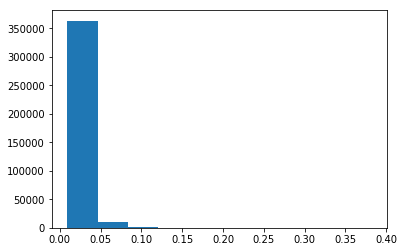

In [28]:
gsigma=1./np.sqrt(pix[depth_keyword+"_G"])
rsigma=1./np.sqrt(pix[depth_keyword+"_R"])
zsigma=1./np.sqrt(pix[depth_keyword+"_Z"])
plt.hist(gsigma)
plt.show()

In [29]:
def getdper(g,r,z):
    wdec = dec > -30
    gsl = gsigma[wdec]
    rsl = rsigma[wdec]
    zsl = zsigma[wdec]
    ds = (gsl > g) & (rsl > r) & (zsl > z)
    return len(gsl[ds])/len(gsl)
getdper(.1,.1,.1)

0.0002617356814763043

In [30]:
# keep same random number
grand = np.random.normal(size=gflux.shape)
rrand = np.random.normal(size=rflux.shape)
zrand = np.random.normal(size=zflux.shape)

In [31]:
photz = truth['hsc_mizuki_photoz_best']

In [32]:
print(len(gsigma),len(pix))

374065 374065


In [33]:
def ELGeffcalc(gsig,rsig,zsig,south=True,snrc=True,zmin=-1,zmax=20):
    '''
    calculate the ELG efficiency for given g,r,z flux uncertainties and a given region's selection
    '''
    wz = (photz > zmin) & (photz <= zmax)
    mgflux = gflux[wz] + grand[wz]*gsig
    mrflux = rflux[wz] + rrand[wz]*rsig
    mzflux = zflux[wz] + zrand[wz]*zsig
    
    combined_snr = np.sqrt(mgflux**2/gsig**2+mrflux**2/rsig**2+mzflux**2/zsig**2) #combined signal to noise; tractor ignores anything < 6
    
    selection = colorcuts_function(gflux=mgflux, rflux=mrflux, zflux=mzflux, w1flux=w1flux, w2flux=w2flux, south=south) 
    if snrc:
        selection *= ( combined_snr > 6 ) * ( mgflux > 4*gsig ) * ( mrflux > 3.5*rsig ) * ( mzflux > 2.*zsig )
        
    efficiency=np.mean(selection.astype(float))/true_mean
    #efficiency_of_true_elgs=np.mean((true_selection*selection).astype(float))/true_mean
    #efficiency_of_stars=np.mean((star_selection*selection).astype(float))/true_mean  
    
    return efficiency#,efficiency_of_true_elgs,efficiency_of_stars
    

In [34]:
def ELGsel(gsig,rsig,zsig,south=True,snrc=True):
    '''
    calculate the ELG selection for given g,r,z flux uncertainties and a given region's selection
    '''
    mgflux = gflux + grand*gsig
    mrflux = rflux + rrand*rsig
    mzflux = zflux + zrand*zsig
    
    combined_snr = np.sqrt(mgflux**2/gsig**2+mrflux**2/rsig**2+mzflux**2/zsig**2) #combined signal to noise; tractor ignores anything < 6
    
    selection = colorcuts_function(gflux=mgflux, rflux=mrflux, zflux=mzflux, w1flux=w1flux, w2flux=w2flux, south=south) 
    if snrc:
        selection *= ( combined_snr > 6 ) * ( mgflux > 4*gsig ) * ( mrflux > 3.5*rsig ) * ( mzflux > 2.*zsig )
    return selection,mgflux,mrflux,mzflux

2304
8571 8156


/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py:315: RuntimeWarning: invalid value encountered in greater
  elg &= r - z > 0.3                  # blue cut.
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py:316: RuntimeWarning: invalid value encountered in less
  elg &= r - z < 1.6                  # red cut.
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py:317: RuntimeWarning: invalid value encountered in less
  elg &= g - r < -1.2*(r - z) + 1.6   # OII flux cut.
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py:323: RuntimeWarning: invalid value encountered in less
  elg &= g - r < 1.15*(r - z) - 0.15
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid val

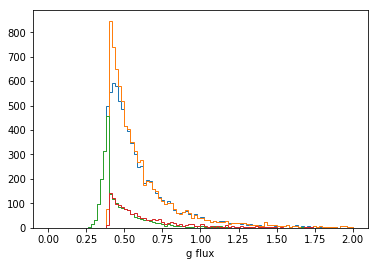

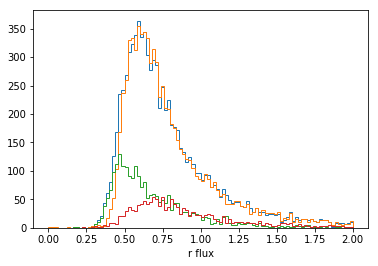

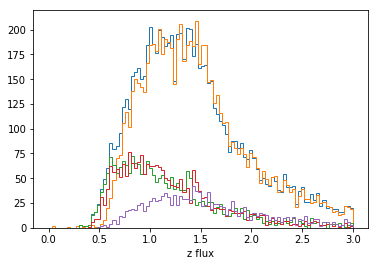

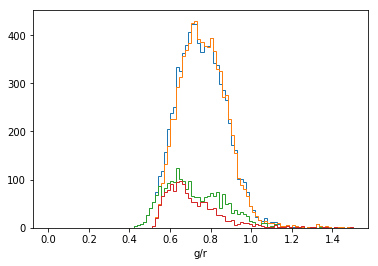

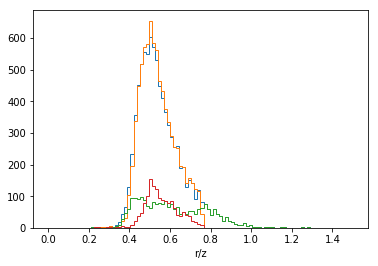

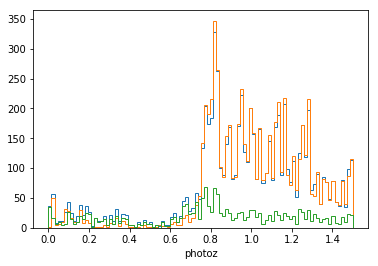

In [35]:
sel,mg,mr,mz = ELGsel(0.04,0.06,.1)
out = ~true_selection & sel

zout = sel & (photz < 0.8)
print(len(gflux[out]))
print(len(gflux[sel]),len(gflux[true_selection]))
plt.hist(gflux[sel],range=(0,2),bins=100,histtype='step')
plt.hist(gflux[true_selection],range=(0,2),bins=100,histtype='step')
plt.hist(gflux[out],range=(0,2),bins=100,histtype='step')
plt.hist(mg[zout],range=(0,2),bins=100,histtype='step')
plt.xlabel('g flux')
plt.show()
plt.hist(rflux[sel],range=(0,2),bins=100,histtype='step')
plt.hist(rflux[true_selection],range=(0,2),bins=100,histtype='step')
plt.hist(rflux[out],range=(0,2),bins=100,histtype='step')
plt.hist(mr[zout],range=(0,2),bins=100,histtype='step')
plt.xlabel('r flux')
plt.show()
plt.hist(zflux[sel],range=(0,3),bins=100,histtype='step')
plt.hist(zflux[true_selection],range=(0,3),bins=100,histtype='step')
plt.hist(zflux[out],range=(0,3),bins=100,histtype='step')
plt.hist(mz[out],range=(0,3),bins=100,histtype='step')
plt.hist(mz[zout],range=(0,3),bins=100,histtype='step')
plt.xlabel('z flux')
plt.show()
plt.hist(gflux[sel]/rflux[sel],range=(0,1.5),bins=100,histtype='step')
plt.hist(gflux[true_selection]/rflux[true_selection],range=(0,1.5),bins=100,histtype='step')
plt.hist(gflux[out]/rflux[out],range=(0,1.5),bins=100,histtype='step')
plt.hist(mg[zout]/mr[zout],range=(0,1.5),bins=100,histtype='step')
plt.xlabel('g/r')
plt.show()
plt.hist(rflux[sel]/zflux[sel],range=(0,1.5),bins=100,histtype='step')
plt.hist(rflux[true_selection]/zflux[true_selection],range=(0,1.5),bins=100,histtype='step')
plt.hist(rflux[out]/zflux[out],range=(0,1.5),bins=100,histtype='step')
plt.hist(mr[zout]/mz[zout],range=(0,1.5),bins=100,histtype='step')
plt.xlabel('r/z')
plt.show()

plt.hist(photz[sel],range=(0,1.5),bins=100,histtype='step')
plt.hist(photz[true_selection],range=(0,1.5),bins=100,histtype='step')
plt.hist(photz[out],range=(0,1.5),bins=100,histtype='step')
plt.xlabel('photoz')
plt.show()


#plt.hist(rflux[sel],range=(0,2),bins=100,histtype='step')
#plt.hist(rflux[true_selection],range=(0,2),bins=100,histtype='step')
#plt.hist(rflux[out],range=(0,2),bins=100,histtype='step')
#plt.xlabel('r flux')
#plt.show()


0.9465196344904352
0.4985058056425611
0.05134908924611495


/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py:315: RuntimeWarning: invalid value encountered in greater
  elg &= r - z > 0.3                  # blue cut.
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py:316: RuntimeWarning: invalid value encountered in less
  elg &= r - z < 1.6                  # red cut.
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py:317: RuntimeWarning: invalid value encountered in less
  elg &= g - r < -1.2*(r - z) + 1.6   # OII flux cut.
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py:323: RuntimeWarning: invalid value encountered in less
  elg &= g - r < 1.15*(r - z) - 0.15
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid val

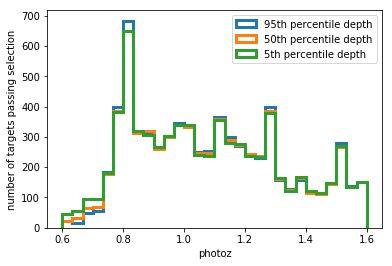

In [88]:
sel1,mg,mr,mz = ELGsel(0.013,0.02,.04) #deep
print(getdper(0.013,0.02,.04))
out1 = ~true_selection & sel1
sel2,mg,mr,mz = ELGsel(0.023,0.041,.06) #slightly worse than median
print(getdper(0.023,0.041,.06))
out2 = ~true_selection & sel2
sel3,mg,mr,mz = ELGsel(0.04,0.065,.085) #shallow
print(getdper(0.04,0.065,.085))
out3 = ~true_selection & sel3

plt.hist(photz[sel1],range=(0.6,1.6),bins=30,histtype='step',linewidth=3)
plt.hist(photz[sel2],range=(0.6,1.6),bins=30,histtype='step',linewidth=3)
plt.hist(photz[sel3],range=(0.6,1.6),bins=30,histtype='step',linewidth=3)
plt.xlabel('photoz')
plt.ylabel('number of targets passing selection')
plt.legend(['95th percentile depth','50th percentile depth','5th percentile depth'],loc='upper right')
plt.show()


In [84]:
da = 0.03,0.055,.075
sel4,mg,mr,mz = ELGsel(da[0],da[1],da[2]) #shallow
print(getdper(da[0],da[1],da[2]))
da = 0.018,0.0344,.051
sel5,mg,mr,mz = ELGsel(da[0],da[1],da[2]) #shallow
print(getdper(da[0],da[1],da[2]))


0.2526267045176729
0.755872514589607


/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py:315: RuntimeWarning: invalid value encountered in greater
  elg &= r - z > 0.3                  # blue cut.
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py:316: RuntimeWarning: invalid value encountered in less
  elg &= r - z < 1.6                  # red cut.
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py:317: RuntimeWarning: invalid value encountered in less
  elg &= g - r < -1.2*(r - z) + 1.6   # OII flux cut.
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py:323: RuntimeWarning: invalid value encountered in less
  elg &= g - r < 1.15*(r - z) - 0.15
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid val

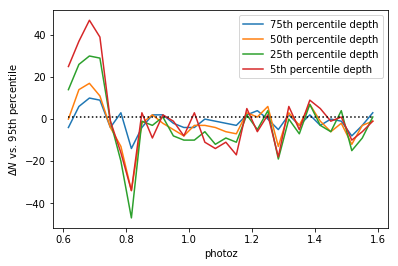

In [86]:
h1 = np.histogram(photz[sel1],range=(0.6,1.6),bins=30)
h2 = np.histogram(photz[sel2],range=(0.6,1.6),bins=30)
h3 = np.histogram(photz[sel3],range=(0.6,1.6),bins=30)
h4 = np.histogram(photz[sel4],range=(0.6,1.6),bins=30)
h5 = np.histogram(photz[sel5],range=(0.6,1.6),bins=30)
xl = np.zeros(len(h1[0]))
for i in range(0,len(xl)):
    xl[i] = (h1[1][i]+h1[1][i+1])/2.
plt.plot(xl,h5[0]-h1[0])
plt.plot(xl,h2[0]-h1[0])
plt.plot(xl,h4[0]-h1[0])
plt.plot(xl,h3[0]-h1[0])
plt.plot(xl,np.ones(len(xl)),'k:')
plt.xlabel('photoz')
plt.ylabel(r'$\Delta N$ vs. 95th percentile')
plt.legend(['75th percentile depth','50th percentile depth','25th percentile depth','5th percentile depth'],loc='upper right')
plt.show()

In [24]:
print(ELGeffcalc(.05,.1,.1,zmin=0.9,zmax=1.6))
print(ELGeffcalc(.2,.2,.2,snrc=False))

2.16374405715
2.19997547818


/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py:315: RuntimeWarning: invalid value encountered in greater
  elg &= r - z > 0.3                  # blue cut.
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py:316: RuntimeWarning: invalid value encountered in less
  elg &= r - z < 1.6                  # red cut.
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py:317: RuntimeWarning: invalid value encountered in less
  elg &= g - r < -1.2*(r - z) + 1.6   # OII flux cut.
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py:323: RuntimeWarning: invalid value encountered in less
  elg &= g - r < 1.15*(r - z) - 0.15
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid val

In [25]:
efficiency1 =np.zeros(npix)
efficiency2 =np.zeros(npix)
efficiency3 =np.zeros(npix)
for j in range(0,len(pix)):# loop on sky pixels using funciton

    if j%5000==0 : print("{}/{}, {:3.2f}%".format(j,ii.size,float(j)/ii.size*100.))
    
    gsig = gsigma[j]*10**(0.4*R_G*pix["EBV"][j])
    rsig = rsigma[j]*10**(0.4*R_R*pix["EBV"][j])
    zsig = zsigma[j]*10**(0.4*R_Z*pix["EBV"][j])
    #do for three redshift ranges and for overall
    eff = ELGeffcalc(gsig,rsig,zsig,south=True)    
    efficiency[j]=eff
    eff = ELGeffcalc(gsig,rsig,zsig,south=True,zmin=0.6,zmax=0.8)
    efficiency1[j]=eff
    eff = ELGeffcalc(gsig,rsig,zsig,south=True,zmin=0.8,zmax=1.1)
    efficiency2[j]=eff
    eff = ELGeffcalc(gsig,rsig,zsig,south=True,zmin=1.1,zmax=1.6)
    efficiency3[j]=eff

    #efficiency_of_true_elgs[j]=efft
    #efficiency_of_stars[j]=effs

0/374065, 0.00%


/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py:315: RuntimeWarning: invalid value encountered in greater
  elg &= r - z > 0.3                  # blue cut.
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py:316: RuntimeWarning: invalid value encountered in less
  elg &= r - z < 1.6                  # red cut.
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py:317: RuntimeWarning: invalid value encountered in less
  elg &= g - r < -1.2*(r - z) + 1.6   # OII flux cut.
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py:323: RuntimeWarning: invalid value encountered in less
  elg &= g - r < 1.15*(r - z) - 0.15
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid val

5000/374065, 1.34%
10000/374065, 2.67%
15000/374065, 4.01%
20000/374065, 5.35%
25000/374065, 6.68%
30000/374065, 8.02%
35000/374065, 9.36%
40000/374065, 10.69%
45000/374065, 12.03%
50000/374065, 13.37%
55000/374065, 14.70%
60000/374065, 16.04%
65000/374065, 17.38%
70000/374065, 18.71%
75000/374065, 20.05%
80000/374065, 21.39%
85000/374065, 22.72%
90000/374065, 24.06%
95000/374065, 25.40%
105000/374065, 28.07%
110000/374065, 29.41%
115000/374065, 30.74%
120000/374065, 32.08%
125000/374065, 33.42%
130000/374065, 34.75%
135000/374065, 36.09%
140000/374065, 37.43%
145000/374065, 38.76%
150000/374065, 40.10%
155000/374065, 41.44%
160000/374065, 42.77%
165000/374065, 44.11%
170000/374065, 45.45%
175000/374065, 46.78%
180000/374065, 48.12%
185000/374065, 49.46%
190000/374065, 50.79%
195000/374065, 52.13%
200000/374065, 53.47%
205000/374065, 54.80%
210000/374065, 56.14%
215000/374065, 57.48%
220000/374065, 58.81%
225000/374065, 60.15%
230000/374065, 61.49%
235000/374065, 62.82%
240000/374065, 

In [49]:
print(i)
#for j in range(0,len(pix)):# loop on sky pixels

#    if j%5000==0 : print("{}/{}, {:3.2f}%".format(j,ii.size,float(j)/ii.size*100.))
    
#    gsig = gsigma[j]*10**(0.4*R_G*pix["EBV"][j])
#    rsig = rsigma[j]*10**(0.4*R_R*pix["EBV"][j])
#    zsig = zsigma[j]*10**(0.4*R_Z*pix["EBV"][j])
    
#    mgflux = gflux + grand*gsig
#    mrflux = rflux + rrand*rsig
#    mzflux = zflux + zrand*zsig
    
#    combined_snr = np.sqrt(mgflux**2/gsig**2+mrflux**2/rsig**2+mzflux**2/zsig**2)

#    selection = colorcuts_function(gflux=mgflux, rflux=mrflux, zflux=mzflux, w1flux=w1flux, w2flux=w2flux, south=True) * ( combined_snr > 6 ) * ( gflux > 4*gsig ) * ( rflux > 3.5*rsig ) * ( zflux > 2.*zsig )
        
#    efficiency[j]=np.mean(selection.astype(float))/true_mean
#    efficiency_of_true_elgs[j]=np.mean((true_selection*selection).astype(float))/true_mean
#    efficiency_of_stars[j]=np.mean((star_selection*selection).astype(float))/true_mean

29


In [50]:
#print(min(efficiency),max(efficiency),np.mean(efficiency))

In [51]:
#plt.hist(efficiency,bins=100)
#plt.show()

In [31]:
outf = os.getenv('SCRATCH')+'/ELGMCeffHSCHPzdiv.fits'


In [32]:
import astropy.io.fits as fits
collist = []
collist.append(fits.Column(name='HPXPIXEL',format='K',array=pix['HPXPIXEL']))
collist.append(fits.Column(name='EFF0608',format='D',array=efficiency1))
collist.append(fits.Column(name='EFF0811',format='D',array=efficiency2))
collist.append(fits.Column(name='EFF1116',format='D',array=efficiency3))
hdu  = fits.BinTableHDU.from_columns(fits.ColDefs(collist))
hdu.writeto(outf,overwrite=True)


In [26]:
p = 2.
efficiencyn = (efficiency/np.mean(efficiency))**p
efficiencyn1 = (efficiency1/np.mean(efficiency1))**p
efficiencyn2 = (efficiency2/np.mean(efficiency2))**p
efficiencyn3 = (efficiency3/np.mean(efficiency3))**p

In [27]:
import healpy
th,phi = healpy.pix2ang(HPXNSIDE,pix['HPXPIXEL'],nest=True)
def thphi2radec(theta,phi):
    return 180./np.pi*phi,-(180./np.pi*theta-90)
ra,dec = thphi2radec(th,phi)

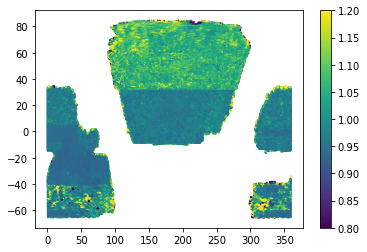

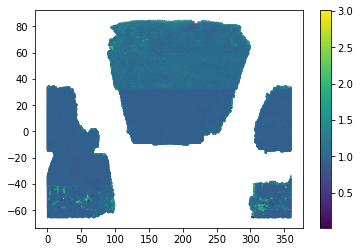

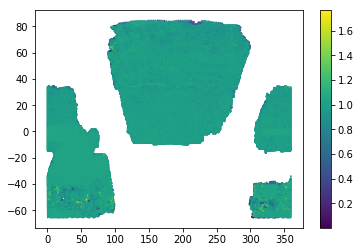

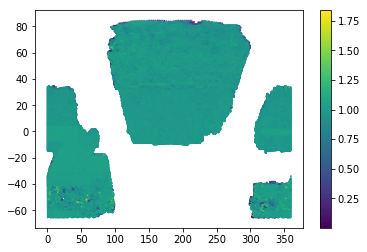

In [37]:
plt.scatter(ra,dec,c=efficiencyn,s=.1,vmin=.8,vmax=1.2)
plt.colorbar()
plt.show()
plt.scatter(ra,dec,c=efficiencyn1,s=.1)
plt.colorbar()
plt.show()
plt.scatter(ra,dec,c=efficiencyn2,s=.1)
plt.colorbar()
plt.show()
plt.scatter(ra,dec,c=efficiencyn3,s=.1)
plt.colorbar()
plt.show()

In [33]:
gsigl = gsigma*10**(0.4*R_G*pix["EBV"])
rsigl = rsigma*10**(0.4*R_R*pix["EBV"])
zsigl = zsigma*10**(0.4*R_Z*pix["EBV"])


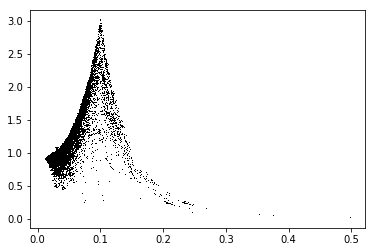

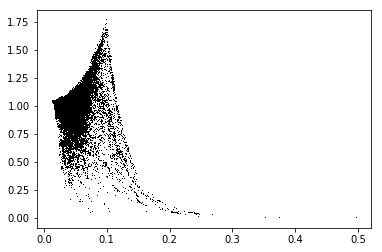

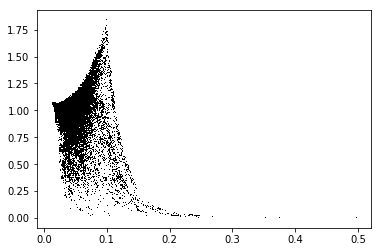

In [36]:
plt.plot(gsigl,efficiencyn1,'k,')
plt.show()
plt.plot(gsigl,efficiencyn2,'k,')
plt.show()
plt.plot(gsigl,efficiencyn3,'k,')
plt.show()

In [55]:
old = fitsio.read(os.getenv('SCRATCH')+'/ELGMCeffHSCHP.fits')

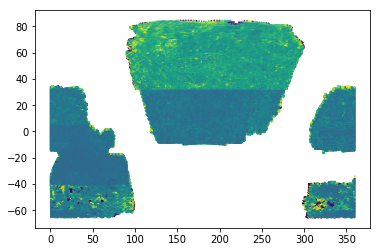

In [56]:
th,phi = healpy.pix2ang(HPXNSIDE,old['HPXPIXEL'],nest=True)
ra,dec = thphi2radec(th,phi)
plt.scatter(ra,dec,c=old['EFF'],s=.1,vmin=.9,vmax=1.2)
plt.show()

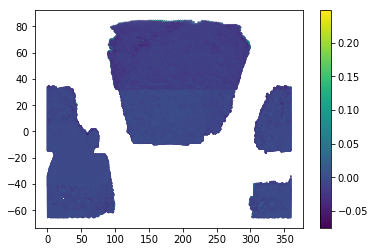

In [57]:
plt.scatter(ra,dec,c=efficiency-old['EFF'],s=.1)
plt.colorbar()
plt.show()

In [58]:
print(np.mean(efficiency-old['EFF']))

-0.00583528889854


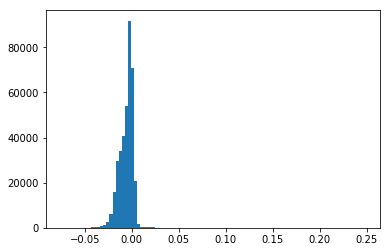

In [59]:
plt.hist(efficiency-old['EFF'],bins=100)
plt.show()


In [60]:
gsigd = gsigma*10**(0.4*R_G*pix["EBV"])
rsigd = rsigma*10**(0.4*R_R*pix["EBV"])
zsigd = zsigma*10**(0.4*R_Z*pix["EBV"])


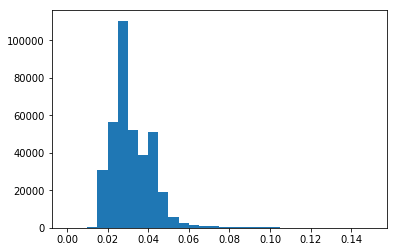

In [61]:
plt.hist(gsigd,bins=30,range=(0,.15))
plt.show()

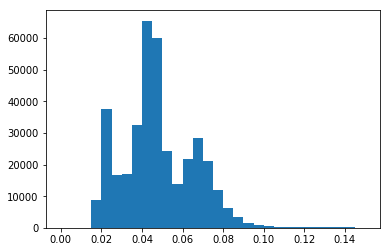

In [62]:
plt.hist(rsigd,bins=30,range=(0,0.15))
plt.show()

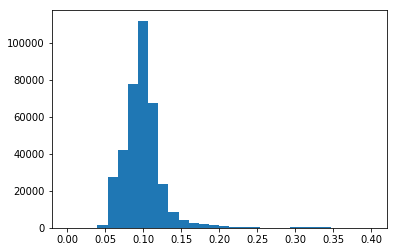

In [63]:
plt.hist(zsigd,bins=30,range=(0,0.4))
plt.show()

In [64]:
#now check histograms for actual data
elgf = os.getenv('SCRATCH')+'/ELGtargetinfo.fits'
felg = fitsio.read(elgf)

In [65]:
gsigmad=1./np.sqrt(felg[depth_keyword+"_G"])
rsigmad=1./np.sqrt(felg[depth_keyword+"_R"])
zsigmad=1./np.sqrt(felg[depth_keyword+"_Z"])


/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


In [66]:
gsige = gsigmad*10**(0.4*R_G*felg["EBV"])
rsige = rsigmad*10**(0.4*R_R*felg["EBV"])
zsige = zsigmad*10**(0.4*R_Z*felg["EBV"])


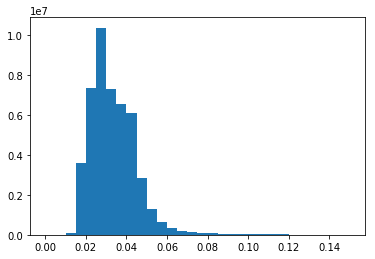

In [67]:
plt.hist(gsige,bins=30,range=(0,.15))
plt.show()

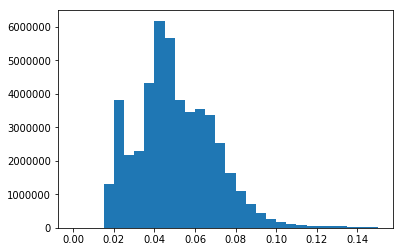

In [68]:
plt.hist(rsige,bins=30,range=(0,.15))
plt.show()

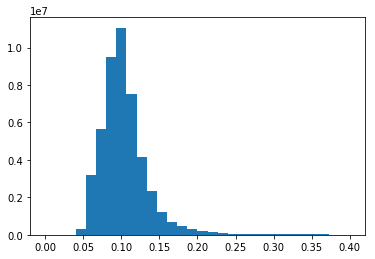

In [69]:
plt.hist(zsige,bins=30,range=(0,.4))
plt.show()

50**3.

In [ ]:
50**3.

125000.0

In [ ]:
30**3.

27000.0

In [29]:
fout = os.getenv('SCRATCH')+'/ELGeffnosnrgridsouth.dat'
fo = open(fout,'w')
fo.write('#gsig rsig zsig target_elg_eff true_elg_eff star_eff\n')
md = 0
xdg = 0.15
xdr = 0.15
xdz = 0.4
ngp = 30 #number of grid points for each band
for i in range(0,ngp):    
    dg = (xdg-md)/float(ngp)*i+0.5*(xdg-md)/float(ngp)
    for j in range(0,ngp):
        dr = (xdr-md)/float(ngp)*j+0.5*(xdr-md)/float(ngp)
        for k in range(0,ngp):
            dz = (xdz-md)/float(ngp)*k+0.5*(xdz-md)/float(ngp)
            eff,efft,effs = ELGeffcalc(dg,dr,dz,south=True,snrc=False)
            fo.write(str(dg)+' '+str(dr)+' '+str(dz)+' '+str(eff)+' '+str(efft)+' '+str(effs)+'\n')
            #if i == 0:
    print(i,dg,dr,dz,eff)        
fo.close()            

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py:315: RuntimeWarning: invalid value encountered in greater
  elg &= r - z > 0.3                  # blue cut.
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py:316: RuntimeWarning: invalid value encountered in less
  elg &= r - z < 1.6                  # red cut.
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py:317: RuntimeWarning: invalid value encountered in less
  elg &= g - r < -1.2*(r - z) + 1.6   # OII flux cut.
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py:323: RuntimeWarning: invalid value encountered in less
  elg &= g - r < 1.15*(r - z) - 0.15


0 0.0025 0.1475 0.39333333333333337 0.963707699853
1 0.0075 0.1475 0.39333333333333337 0.967999019127
2 0.0125 0.1475 0.39333333333333337 0.970573810692
3 0.017499999999999998 0.1475 0.39333333333333337 0.974497302599
4 0.0225 0.1475 0.39333333333333337 0.983938205002
5 0.0275 0.1475 0.39333333333333337 0.989946051986
6 0.0325 0.1475 0.39333333333333337 1.00257479156
7 0.037500000000000006 0.1475 0.39333333333333337 1.0182687592
8 0.0425 0.1475 0.39333333333333337 1.03457577244
9 0.0475 0.1475 0.39333333333333337 1.05076017656
10 0.052500000000000005 0.1475 0.39333333333333337 1.07405590976
11 0.0575 0.1475 0.39333333333333337 1.09771947033
12 0.0625 0.1475 0.39333333333333337 1.11770475723
13 0.0675 0.1475 0.39333333333333337 1.14615007357
14 0.07250000000000001 0.1475 0.39333333333333337 1.17790583619
15 0.0775 0.1475 0.39333333333333337 1.2117459539
16 0.0825 0.1475 0.39333333333333337 1.24595389897
17 0.08750000000000001 0.1475 0.39333333333333337 1.28249141736
18 0.0925 0.1475 0.3

In [30]:
fout = os.getenv('SCRATCH')+'/ELGeffnosnrgridnorth.dat'
fo = open(fout,'w')
fo.write('#gsig rsig zsig target_elg_eff true_elg_eff star_eff\n')
md = 0
xdg = 0.15
xdr = 0.15
xdz = 0.4
ngp = 30 #number of grid points for each band
for i in range(0,ngp):    
    dg = (xdg-md)/float(ngp)*i+0.5*(xdg-md)/float(ngp)
    for j in range(0,ngp):
        dr = (xdr-md)/float(ngp)*j+0.5*(xdr-md)/float(ngp)
        for k in range(0,ngp):
            dz = (xdz-md)/float(ngp)*k+0.5*(xdz-md)/float(ngp)
            eff,efft,effs = ELGeffcalc(dg,dr,dz,south=False,snrc=False)
            fo.write(str(dg)+' '+str(dr)+' '+str(dz)+' '+str(eff)+' '+str(efft)+' '+str(effs)+'\n')
            #if i == 0:
    print(i,dg,dr,dz,eff)        
fo.close()            

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py:315: RuntimeWarning: invalid value encountered in greater
  elg &= r - z > 0.3                  # blue cut.
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py:316: RuntimeWarning: invalid value encountered in less
  elg &= r - z < 1.6                  # red cut.
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py:317: RuntimeWarning: invalid value encountered in less
  elg &= g - r < -1.2*(r - z) + 1.6   # OII flux cut.
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py:326: RuntimeWarning: invalid value encountered in less
  elg &= g - r < 1.15*(r - z) - 0.35  # remove stars and low-z galaxies.


0 0.0025 0.1475 0.39333333333333337 0.811549779304
1 0.0075 0.1475 0.39333333333333337 0.814982834723
2 0.0125 0.1475 0.39333333333333337 0.816208925944
3 0.017499999999999998 0.1475 0.39333333333333337 0.825649828347
4 0.0225 0.1475 0.39333333333333337 0.836194212849
5 0.0275 0.1475 0.39333333333333337 0.846861206474
6 0.0325 0.1475 0.39333333333333337 0.862064737616
7 0.037500000000000006 0.1475 0.39333333333333337 0.879230014713
8 0.0425 0.1475 0.39333333333333337 0.897989210397
9 0.0475 0.1475 0.39333333333333337 0.917116233448
10 0.052500000000000005 0.1475 0.39333333333333337 0.942251103482
11 0.0575 0.1475 0.39333333333333337 0.972658165768
12 0.0625 0.1475 0.39333333333333337 1.00245218244
13 0.0675 0.1475 0.39333333333333337 1.03310446297
14 0.07250000000000001 0.1475 0.39333333333333337 1.06902893575
15 0.0775 0.1475 0.39333333333333337 1.10666993624
16 0.0825 0.1475 0.39333333333333337 1.14369789112
17 0.08750000000000001 0.1475 0.39333333333333337 1.18906326631
18 0.0925 0.

In [ ]:
dn = np.loadtxt(fout).transpose()

In [ ]:
w = d[2] == 0.1
plt.scatter(d[0][w],d[1][w],c=d[3][w])
plt.xlabel('g sigma')
plt.ylabel('r sigma')
plt.colorbar()
plt.show()

NameError: name 'd' is not defined

In [ ]:
w = dn[2] == 0.1
plt.scatter(dn[0][w],dn[1][w],c=dn[3][w])
plt.xlabel('g sigma')
plt.ylabel('r sigma')
plt.colorbar()
plt.show()

In [ ]:
w = d[0] == 0.0325
plt.scatter(d[1][w],d[2][w],c=d[3][w])
plt.xlabel('r sigma')
plt.ylabel('z sigma')
plt.colorbar()
plt.show()

In [ ]:
print(np.unique(d[2]))

In [ ]:
w = d[1] == 0.0325
plt.scatter(d[0][w],d[2][w],c=d[3][w])
plt.xlabel('g sigma')
plt.ylabel('z sigma')
plt.colorbar()
plt.show()